## CODE iii

In [ ]:
# =============================================
# 🔶 Fuzzy Time Series Dinamis (order=2) - Full Script
# =============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ----------------------------
# 0) Pengaturan
# ----------------------------
np.random.seed(42)
future_steps = 12
order = 2                       # order model (gunakan 2 untuk mempertimbangkan 2 lag)
noise_scale_factor = 0.03       # noise kecil di scaled space (0 => deterministik)
z_value = 1.96                  # untuk 95% CI

In [ ]:

# ----------------------------
# 1) Baca data & agregasi bulanan
# ----------------------------
df = pd.read_csv("Data Forecast Emas.csv")
df['Waktu'] = pd.to_datetime(df['Waktu'], format='%d/%m/%Y %H:%M')
df = df.sort_values('Waktu')

df['month'] = df['Waktu'].dt.to_period('M')
monthly_df = df.groupby('month')['Xt'].mean().reset_index()
monthly_df['month'] = monthly_df['month'].dt.to_timestamp()
monthly_df.to_csv("01_data_bulanan.csv", index=False)
print("✅ Data bulanan disimpan di 01_data_bulanan.csv")

✅ Data bulanan disimpan di 01_data_bulanan.csv


In [ ]:
# ----------------------------
# 2) Normalisasi (MinMax) - scaled space dipakai sepanjang model
# ----------------------------
scaler = MinMaxScaler()
monthly_df['Xt_scaled'] = scaler.fit_transform(monthly_df[['Xt']])
monthly_df.to_csv("02_scaled_data.csv", index=False)

In [ ]:
# ----------------------------
# 3) Tentukan himpunan semesta & interval (adaptif)
#    Gunakan lebih banyak interval agar model punya resolusi
# ----------------------------
U_min = monthly_df['Xt_scaled'].min()
U_max = monthly_df['Xt_scaled'].max()

# aturan sederhana: gunakan sqrt(n) atau minimal 8
n_interval = max(8, int(np.round(np.sqrt(len(monthly_df) * 2))))
intervals = np.linspace(U_min, U_max, n_interval + 1)

interval_df = pd.DataFrame({
    'Interval': [f"A{i+1}" for i in range(n_interval)],
    'Batas_Bawah': intervals[:-1],
    'Batas_Atas': intervals[1:]
})
interval_df.to_csv("03_intervals.csv", index=False)

In [ ]:

# ----------------------------
# 4) Fuzzifikasi (menggunakan scaled space)
# ----------------------------
def fuzzify_scaled(value_scaled):
    # value_scaled diharapkan berada di dalam [U_min, U_max]
    for i in range(n_interval):
        if intervals[i] <= value_scaled < intervals[i + 1]:
            return f"A{i+1}"
    return f"A{n_interval}"

monthly_df['Fuzzy'] = monthly_df['Xt_scaled'].apply(fuzzify_scaled)
monthly_df.to_csv("04_fuzzifikasi.csv", index=False)

In [ ]:
# ----------------------------
# 5) Bentuk FLR & FLRG untuk order = 2
#    Key: tuple (A_{t-2}, A_{t-1}) -> list of A_t
# ----------------------------
FLR = []
for i in range(order, len(monthly_df)):
    key = tuple(monthly_df.loc[i-order:i-1, 'Fuzzy'].values)  # tuple of previous 'order' fuzzy labels
    target = monthly_df.loc[i, 'Fuzzy']
    FLR.append((key, target))

FLRG = {}
for key, tgt in FLR:
    if key not in FLRG:
        FLRG[key] = []
    if tgt not in FLRG[key]:
        FLRG[key].append(tgt)

flrg_df = pd.DataFrame({
    'From': ['+'.join(k) for k in FLRG.keys()],
    'To': [','.join(v) for v in FLRG.values()]
})
flrg_df.to_csv("05_flrg_order2.csv", index=False)

In [ ]:

# ----------------------------
# 6) Defuzzifikasi - buat center (pusat tiap interval) di SCALED space
# ----------------------------
centers_scaled = [(intervals[i] + intervals[i + 1]) / 2 for i in range(n_interval)]
center_dict_scaled = {f"A{i+1}": centers_scaled[i] for i in range(n_interval)}


In [ ]:

# ----------------------------
# 7) Prediksi historis memakai order=2 (untuk evaluasi)
#    Kita mulai menghasilkan forecast_scaled_hist untuk t = order ... end-1
# ----------------------------
forecast_scaled_hist = []
for i in range(order, len(monthly_df)):
    key = tuple(monthly_df.loc[i-order:i-1, 'Fuzzy'].values)
    if key in FLRG:
        next_labels = FLRG[key]
        next_center_scaled = np.mean([center_dict_scaled[l] for l in next_labels])
    else:
        # fallback: gunakan last label (A_{t-1}) center (lebih konservatif)
        last_label = monthly_df.loc[i-1, 'Fuzzy']
        next_center_scaled = center_dict_scaled[last_label]
    forecast_scaled_hist.append(next_center_scaled)

# inverse transform historical forecast -> nilai asli
forecast_values_hist = scaler.inverse_transform(np.array(forecast_scaled_hist).reshape(-1, 1)).flatten()

# buat dataframe historis prediksi untuk align dengan actual (t = order ... end-1)
forecast_hist_df = pd.DataFrame({
    'month': monthly_df['month'].iloc[order:].reset_index(drop=True),
    'actual': monthly_df['Xt'].iloc[order:].reset_index(drop=True),
    'forecast': forecast_values_hist
})
forecast_hist_df.to_csv("06_forecast_bulanan_order2.csv", index=False)

In [ ]:

# ----------------------------
# 8) Hitung residual & statistik (di skala asli) -> untuk CI
# ----------------------------
resid_real = forecast_hist_df['actual'].values - forecast_hist_df['forecast'].values
std_error_real = np.std(resid_real, ddof=1) if len(resid_real) > 1 else 0.0

# Untuk manipulasi noise saat simulasi, hitung std di scaled space (dengan transform)
if len(resid_real) > 1:
    resid_scaled = scaler.transform(resid_real.reshape(-1, 1)).flatten()
    std_error_scaled = np.std(resid_scaled, ddof=1)
else:
    std_error_scaled = 0.0

# Metrik evaluasi (gunakan historical forecasts)
rmse = math.sqrt(mean_squared_error(forecast_hist_df['actual'], forecast_hist_df['forecast']))
mae = mean_absolute_error(forecast_hist_df['actual'], forecast_hist_df['forecast'])
mape = np.mean(np.abs((forecast_hist_df['actual'] - forecast_hist_df['forecast']) / forecast_hist_df['actual'])) * 100

print(f"Historical metrics (order={order}): RMSE={rmse:,.2f}, MAE={mae:,.2f}, MAPE={mape:.2f}%")
print("Std error (real):", std_error_real, "| Std error (scaled):", std_error_scaled)

Historical metrics (order=2): RMSE=47,726.04, MAE=40,342.63, MAPE=4.60%
Std error (real): 42691.972019975394 | Std error (scaled): 0.033983469958754765


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# ----------------------------
# 9) Forecast 12 bulan ke depan (iteratif) di SCALED space
# ----------------------------
# Ambil dua fuzzy terakhir sebagai initial key
last_labels = tuple(monthly_df['Fuzzy'].iloc[-order:].values)  # (A_{T-1}, A_T) for order=2
current_key = last_labels
future_forecast_scaled = []
future_labels = []

# ambil min/max scaled untuk clamp
scaled_min = intervals[0]
scaled_max = intervals[-1]

for step in range(future_steps):
    if current_key in FLRG:
        next_labels = FLRG[current_key]
        next_center_scaled = np.mean([center_dict_scaled[l] for l in next_labels])
    else:
        # fallback: gunakan center dari last label of the key
        next_center_scaled = center_dict_scaled[current_key[-1]]

    # tambahkan noise kecil (di scaled space)
    noise = np.random.normal(0, std_error_scaled * noise_scale_factor)
    next_center_scaled = next_center_scaled + noise

    # clamp agar tidak keluar terlalu jauh dari rentang training
    next_center_scaled = np.clip(next_center_scaled, scaled_min * 0.95, scaled_max * 1.05)

    future_forecast_scaled.append(next_center_scaled)
    new_label = fuzzify_scaled(next_center_scaled)
    future_labels.append(new_label)

    # update key: shift left and append new_label (untuk order>2, generalisasi)
    current_key = tuple(list(current_key[1:]) + [new_label])

# inverse transform future -> real scale & pastikan non-negatif
future_forecast_real = scaler.inverse_transform(np.array(future_forecast_scaled).reshape(-1, 1)).flatten()
future_forecast_real = np.maximum(0, future_forecast_real)

# Confidence interval di skala real
upper_future = future_forecast_real + z_value * std_error_real
lower_future = future_forecast_real - z_value * std_error_real
lower_future = np.maximum(0, lower_future)

# Buat tanggal 12 bulan ke depan
last_month = monthly_df['month'].iloc[-1]
future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')

future_df = pd.DataFrame({
    'month': future_months,
    'forecast_value': future_forecast_real,
    'fuzzy_label': future_labels,
    'upper_bound': upper_future,
    'lower_bound': lower_future
})
future_df.to_csv("09_forecast_12bulan_ke_depan_order2.csv", index=False)
print("✅ Hasil peramalan dinamis disimpan di 09_forecast_12bulan_ke_depan_order2.csv")


✅ Hasil peramalan dinamis disimpan di 09_forecast_12bulan_ke_depan_order2.csv


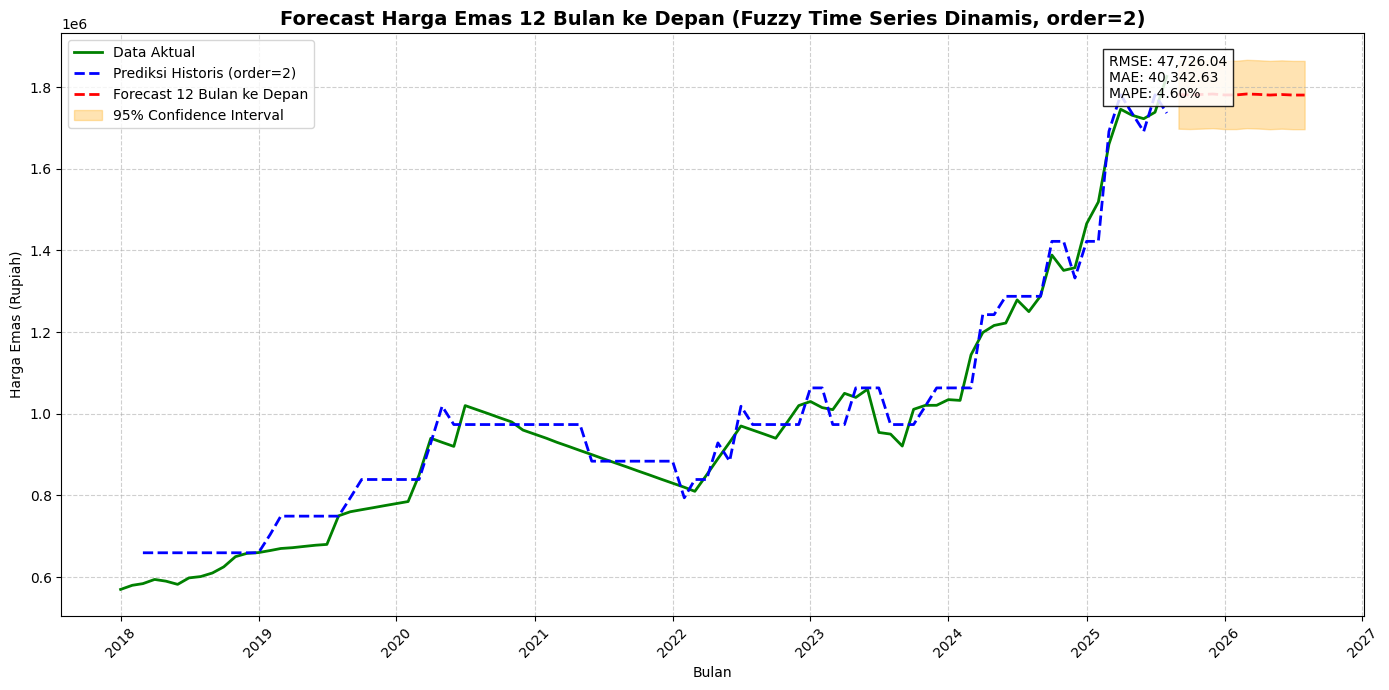

✅ Visualisasi disimpan: 10_plot_forecast_12bulan_order2.png


In [ ]:

# ----------------------------
# 10) Visualisasi gabungan (aktual, prediksi historis, forecast 12 bulan)
# ----------------------------
plt.figure(figsize=(14, 7))
plt.plot(monthly_df['month'], monthly_df['Xt'], label='Data Aktual', color='green', linewidth=2)
plt.plot(forecast_hist_df['month'], forecast_hist_df['forecast'], label='Prediksi Historis (order=2)', color='blue', linestyle='--', linewidth=2)
plt.plot(future_df['month'], future_df['forecast_value'], label='Forecast 12 Bulan ke Depan', color='red', linestyle='--', linewidth=2)
plt.fill_between(future_df['month'], future_df['lower_bound'], future_df['upper_bound'], color='orange', alpha=0.3, label='95% Confidence Interval')

plt.title("Forecast Harga Emas 12 Bulan ke Depan (Fuzzy Time Series Dinamis, order=2)", fontsize=14, weight='bold')
plt.xlabel("Bulan")
plt.ylabel("Harga Emas (Rupiah)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xticks(rotation=45)

# Tambahkan metrik evaluasi di pojok kanan atas
ymax = max(monthly_df['Xt'].max(), future_df['upper_bound'].max())
xpos = forecast_hist_df['month'].iloc[max(0, len(forecast_hist_df)-6)]
plt.text(xpos, ymax * 0.95,
         f"RMSE: {rmse:,.2f}\nMAE: {mae:,.2f}\nMAPE: {mape:.2f}%",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.85))

plt.tight_layout()
plt.savefig("10_plot_forecast_12bulan_order2.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Visualisasi disimpan: 10_plot_forecast_12bulan_order2.png")